Load `torch`. Note the version on colab can lag behind the most current release. If you need something new you can install using e.g. !pip3 install torch==1.4.0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn

from importlib import reload
reload(biophysnn)

<module 'biophysnn' from '/gpfs/commons/home/daknowles/pooledRBPs/biophysical_cnn/biophysnn.py'>

## Loading data

In [2]:
binding_data = pd.read_csv("/gpfs/commons/home/daknowles/RIPnet/all_hnrnpk_rep1_stranded.narrowPeak.gz", sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data

,chrom,start,end,name,score,strand
0,chr1,16099,16580,all_hnrnpk_rep1_neg_peak_35,81,-
1,chr1,19237,19896,all_hnrnpk_rep1_neg_peak_36,48,-
2,chr1,136471,137136,all_hnrnpk_rep1_neg_peak_37,73,-
3,chr1,186383,187169,all_hnrnpk_rep1_neg_peak_38,54,-
4,chr1,190825,191102,all_hnrnpk_rep1_neg_peak_39,51,-
...,...,...,...,...,...,...
149418,chr9,138179008,138179394,all_hnrnpk_rep1_pos_peak_74674,72,+
149419,chr9,138232102,138232344,all_hnrnpk_rep1_pos_peak_74675,362,+
149420,chr9,138232980,138233211,all_hnrnpk_rep1_pos_peak_74676,254,+
149421,chr9,138276024,138276247,all_hnrnpk_rep1_pos_peak_74677,340,+


In [3]:
unbound = pd.read_csv("unbound_regions.bed.gz", 
                      sep = "\t", 
                      names = ["chrom", "start", "end", "name", "strand", "counts", "length"],
                      index_col = False)
unbound

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,chrom,start,end,name,strand,counts,length
0,chr1,17369,17436,ENSG00000278267.1,-,53,68
1,chr1,135141,135895,ENSG00000268903.1,-,903,755
2,chr1,137682,137965,ENSG00000269981.1,-,1206,284
3,chr1,185217,186383,ENSG00000279457.4,-,295,1397
4,chr1,187169,190825,ENSG00000279457.4,-,295,1397
...,...,...,...,...,...,...,...
126565,chrM,14149,14673,ENSG00000198695.2,-,59390,525
126566,chrM,14674,14742,ENSG00000210194.1,-,598,69
126567,chrM,14747,15887,ENSG00000198727.2,+,247327,1141
126568,chrM,15888,15953,ENSG00000210195.2,+,663,66


In [4]:
unbound["score"] = 0
bind_all = pd.concat([binding_data,
           unbound.loc[:, ~unbound.columns.isin(['counts', 'length'])]], 
          axis=0)
bind_all.iloc[10]

chrom                            chr1
start                          629752
end                            629972
name      all_hnrnpk_rep1_pos_peak_23
score                             246
strand                              +
Name: 74767, dtype: object

In [5]:
test_chromosomes = ["chr1"]
test_data = bind_all[ bind_all['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = bind_all[ bind_all['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = bind_all[ bind_all['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / bind_all.shape[0], validation_data.shape[0] / bind_all.shape[0]

(0.09493766126042802, 0.1428707751144192)

We'll also need the human genome, which we provide here as a pickle since it's faster to load compared to reading in a text file. 

It's worth knowing that the human genome has different *versions* that are released as more missing parts are resolved by continued sequencing and assembly efforts. Version `GRCh37` (also called `hg19`) was released in 2009, and `GRCh38` (`hg38`) was released in 2013. We'll be using `hg19` here but `GRCh38` is finally becoming more standard so always check your data is what you think it is. 

This will take a minute or two. 

In [6]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

`genome` is just a dictionary where the keys are the chromosome names and the values are strings representing the actual DNA. Ns represents "missing" regions, typically because the region has too many repetitive sequences making mapping impossible, which is especially the case in [centrosomes](https://en.wikipedia.org/wiki/Centrosome) and [telomeres](https://en.wikipedia.org/wiki/Telomere). Resolving these difficult to map regions is an ongoing effort. 

## Load known PWMs

In [7]:
pwm_dat = np.load("/gpfs/commons/home/daknowles/apex_seq/pwms.npz")
pwm_names = pwm_dat['names']
pwms = pwm_dat['pwms']

pwms[pwms > 0].min()
log_pwms = np.log(pwms + 1e-4)

# Convert to actual PWM
w = torch.tensor(log_pwms, dtype=torch.float).transpose(0,2)
w_norm = w - w.mean(1,keepdims=True)

w_norm.shape

torch.Size([453, 4, 7])

In [8]:
specific_pwms = w_norm[ np.array([ "HNRNPK" in g for g in pwm_names ]) ]
specific_pwms.shape

torch.Size([5, 4, 7])

## Test phys net

In [110]:
res_df = biophysnn.test_settings(specific_pwms, train_data, genome, validation_data)

NameError: name 'test_settings' is not defined

In [87]:
res_df.to_csv("results.tsv", sep = "\t", index = False)

,posmax,motifmax,seqlen,file,motif_then_pos,val_auc,train_auc
0,False,False,100,checkpoints/posmax0_motifmax0_len100.pt,True,0.692046,0.000000
1,False,False,200,checkpoints/posmax0_motifmax0_len200.pt,True,0.741130,0.000000
2,False,False,300,checkpoints/posmax0_motifmax0_len300.pt,True,0.772809,0.000000
3,False,False,400,checkpoints/posmax0_motifmax0_len400.pt,True,0.795636,0.000000
4,False,False,500,checkpoints/posmax0_motifmax0_len500.pt,True,0.808343,0.000000
5,False,False,600,checkpoints/posmax0_motifmax0_len600.pt,True,0.811530,0.000000
6,False,False,700,checkpoints/posmax0_motifmax0_len700.pt,True,0.801749,0.000000
7,False,True,100,checkpoints/posmax0_motifmax1_len100_posthenma...,False,0.679523,0.000000
8,False,True,200,checkpoints/posmax0_motifmax1_len200_posthenma...,False,0.695701,0.000000
9,False,True,300,checkpoints/posmax0_motifmax1_len300_posthenma...,False,0.713980,0.000000


### Analyze results

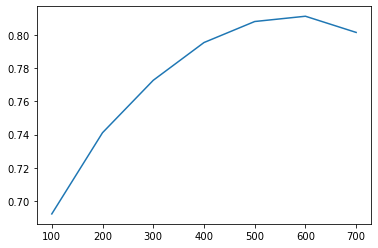

In [94]:
lse_only = res_df[~res_df.posmax & ~res_df.motifmax]
plt.plot(lse_only.seqlen, lse_only.val_auc)

In [98]:
sixh_only = res_df.groupby(["motifmax","posmax","motif_then_pos"]).agg({"val_auc" : "max"})
sixh_only

val_auc
motifmax posmax motif_then_pos          
False    False  True            0.811530
         True   False           0.668820
                True            0.667206
True     False  False           0.727069
                True            0.799355
         True   True            0.631303

The best performance is obtained by using logSumExp across both motifs and positions, which is symmetric in the order of summarization. Taking the max over positions always performs very poorly, suggesting that accounting for multiple binding sites in the region is beneficial, at least for HNRNPK. 

Taking the max over motifs but logSumExp over positions gives intermediate performance. Interestingly, it is better to do the max over motifs first, then logSumExp over positions (rather than logSumExp over positions then max over motifs). This is intuitive. If there are two distinct binding sites in a region, there is no reason to think that the same motif need be used in both. Instead, the max determines how likely the RBP is to bind at any given position, and this is combined by the logSumExp. 

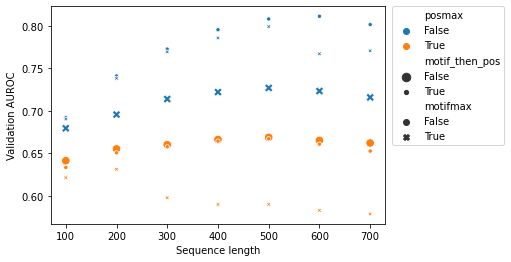

In [14]:
import seaborn as sns
res_df = pd.read_csv("results.tsv", sep="\t", index_col = False)
sns.scatterplot("seqlen", "val_auc", hue = "posmax", style="motifmax", size="motif_then_pos", data = res_df)
plt.xlabel("Sequence length")
plt.ylabel("Validation AUROC")
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)

In [6]:
phys_net = biophysnn.PhysNet(specific_pwms, max_over_positions = False, max_over_motifs = False, seq_len = 600)
phys_net.load_state_dict(torch.load("checkpoints/posmax0_motifmax0_len600.pt"))
for k,v in phys_net.named_parameters(): 
    print(k,v)

motif_scale_unc Parameter containing:
tensor([-0.7110, -2.3722, -2.0333, -1.9900, -0.6066], requires_grad=True)
motif_offset Parameter containing:
tensor([-10.8102, -13.4823, -11.8961,  -6.7172,  -6.7845], requires_grad=True)
scale_unc Parameter containing:
tensor(6.3752, requires_grad=True)
offset Parameter containing:
tensor(-8.2239, requires_grad=True)


In [7]:
phys_net.scale

tensor(6.3769, grad_fn=<SoftplusBackward0>)

In [8]:
phys_net.motif_scale

tensor([0.3996, 0.0892, 0.1230, 0.1281, 0.4351], grad_fn=<SoftplusBackward0>)

### Plot examples

(317, 4)

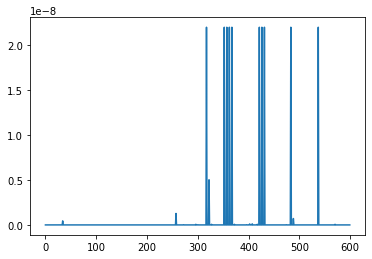

In [87]:
val_dataset = biophysnn.FastBedPeaksDataset(validation_data, genome, phys_net.seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=10000)
for x,y in validation_dataloader: 
    affin = phys_net(x)
    conv_lin = F.conv1d(x, phys_net.pwm, padding = "same") * phys_net.motif_scale[None,:,None] + phys_net.motif_offset[None,:,None]
    per_position = phys_net.scale * conv_lin.logsumexp(1) + phys_net.offset
    break

bound = y == 1.
idx = affin[bound].argmax().item()
plt.plot(per_position[bound][idx].detach().exp().numpy())

argmax_pos = per_position[bound][idx].argmax().item()
argmax_motif = conv_lin[bound][idx,:,argmax_pos].argmax().item()
argmax_pos, argmax_motif

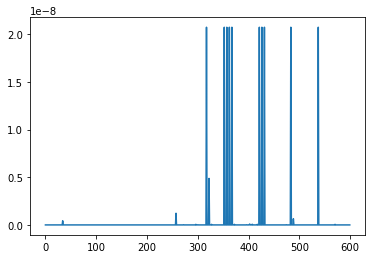

In [91]:
one_motif = phys_net.scale * conv_lin[bound][idx,argmax_motif] + phys_net.offset
plt.plot(one_motif.detach().exp().numpy())

Clusters are cool.

(-0.475, 6.475, -2.8821611404418945, 2.882161855697632)

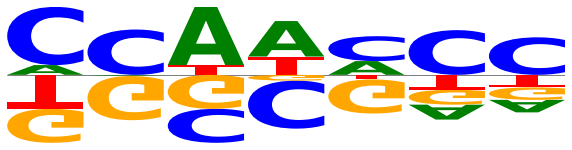

In [88]:
pwm_match = phys_net.pwm[argmax_motif,:,:]
import logomaker
pwm_df = pd.DataFrame(data = pwm_match.detach().t().numpy(), columns=("A","C","G","T"))
crp_logo = logomaker.Logo(pwm_df) 
plt.axis('off')

In [92]:
one_motif.argmax().item()

317

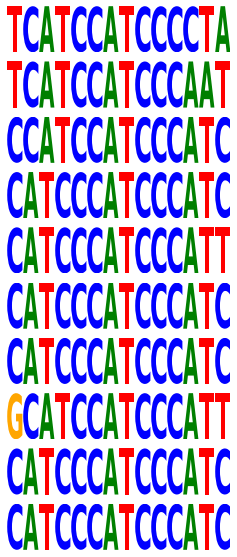

In [99]:
npos = 10
top_pos = one_motif.argsort(descending=True)[:npos]
plt.figure(figsize=(4,npos))
        
for i,tp in enumerate(top_pos):
    ax = plt.subplot(npos,1,i+1)
    seq = x[bound][idx,:,tp-7:tp+7]
    pwm_df = pd.DataFrame(data = seq.detach().t().numpy(), columns=("A","C","G","T"))
    crp_logo = logomaker.Logo(pwm_df, ax= ax) 
    plt.axis('off')

NameError: name 'npos' is not defined

1

## Fine tune PWMs

In [100]:
scaled_pwm = specific_pwms * phys_net.motif_scale[:,None,None]
fine_net = biophysnn.FinePhysNet(scaled_pwm, 
                                 motif_offset = phys_net.motif_offset.data,
                                 scale_unc = phys_net.scale_unc.data, 
                                 offset = phys_net.offset.data, 
                                 seq_len = phys_net.seq_len)
fine_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(fine_net, 
                                                       train_data, 
                                                       validation_data, 
                                                       genome, 
                                                       verbose = True, 
                                                       check_point_filename = "checkpoints/fine_net.pt",
                                                       lr = 0.1) # val auc 0.832

Epoch 1 took 9.72s. Train loss: 0.5597 acc: 0.7446 auc 0.802. Val loss: 0.4886 acc: 0.7788 auc 0.853. Patience left: 10
Epoch 2 took 10.11s. Train loss: 0.5015 acc: 0.7703 auc 0.838. Val loss: 0.4905 acc: 0.7716 auc 0.856. Patience left: 9
Epoch 3 took 9.41s. Train loss: 0.4933 acc: 0.7769 auc 0.844. Val loss: 0.5038 acc: 0.7542 auc 0.860. Patience left: 8
Epoch 4 took 9.57s. Train loss: 0.4952 acc: 0.7738 auc 0.842. Val loss: 0.4686 acc: 0.7910 auc 0.860. Patience left: 10
Epoch 5 took 9.70s. Train loss: 0.4871 acc: 0.7791 auc 0.847. Val loss: 0.4700 acc: 0.7895 auc 0.862. Patience left: 9
Epoch 6 took 9.72s. Train loss: 0.4880 acc: 0.7788 auc 0.847. Val loss: 0.4617 acc: 0.7938 auc 0.864. Patience left: 10
Epoch 7 took 9.79s. Train loss: 0.4884 acc: 0.7778 auc 0.846. Val loss: 0.4661 acc: 0.7946 auc 0.864. Patience left: 9
Epoch 8 took 9.69s. Train loss: 0.4846 acc: 0.7798 auc 0.849. Val loss: 0.4614 acc: 0.7948 auc 0.864. Patience left: 10
Epoch 9 took 9.67s. Train loss: 0.4849 acc:

So fine-tuning moves AUROC from 0.81 to 0.86, and does significantly change the PWMs: 

In [101]:
torch.corrcoef(torch.stack([scaled_pwm.flatten(), fine_net.pwm.cpu().flatten()]))

tensor([[1.0000, 0.4504],
        [0.4504, 1.0000]])

In [139]:
scaled_pwm = specific_pwms * phys_net.motif_scale[:,None,None]
fine_net = biophysnn.FinePhysNet(scaled_pwm, 
                                 motif_offset = phys_net.motif_offset.data,
                                 scale_unc = phys_net.scale_unc.data, 
                                 offset = phys_net.offset.data, 
                                 seq_len = phys_net.seq_len)
fine_net.load_state_dict(torch.load("checkpoints/fine_net.pt"))

<All keys matched successfully>

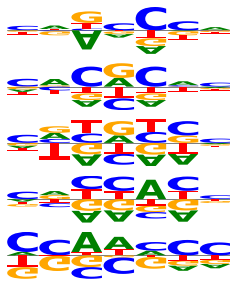

In [13]:
biophysnn.plot_motifs(specific_pwms)

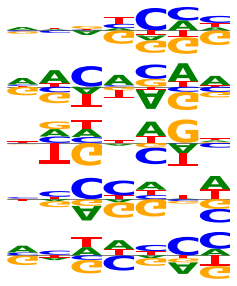

In [104]:
plot_motifs(fine_net.pwm.cpu())

## mCross PWMs

In [105]:
base_dir = "/gpfs/commons/groups/knowles_lab/data/oRNAment/mCross/"
pwm = np.load(base_dir + "mCross_pwm.npy")
meta = pd.read_csv(base_dir + "pwm_meta.tsv", sep = "\t")
meta

,Celltype,RBP,ind
0,HepG2,AGGF1,0
1,HepG2,AGGF1,1
2,HepG2,AGGF1,2
3,HepG2,AGGF1,3
4,HepG2,AGGF1,4
...,...,...,...
1066,K562,ZRANB2,3
1067,K562,ZRANB2,4
1068,K562,ZRANB2,5
1069,K562,ZRANB2,6


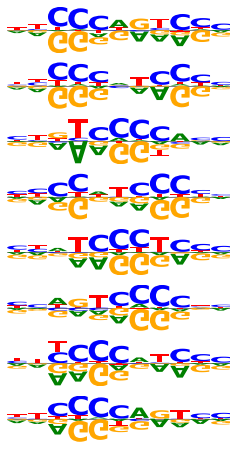

In [106]:
HNRNPK_motifs = (meta.RBP == "HNRNPK") & (meta.Celltype == "HepG2").to_numpy()
HNRNPK_pwm = torch.tensor(pwm[HNRNPK_motifs,:,:], dtype = torch.float)
HNRNPK_pwm -= HNRNPK_pwm.mean(1, keepdims=True)
plot_motifs(HNRNPK_pwm)

In [114]:
reload(biophysnn)
res_df = biophysnn.test_settings(HNRNPK_pwm, 
                                 train_data, 
                                 validation_data, 
                                 genome, 
                                 base_checkpoint_dir = "mCross_checkpoints/")

mCross_checkpoints/posmax0_motifmax0_len100.pt
mCross_checkpoints/posmax0_motifmax0_len200.pt
mCross_checkpoints/posmax0_motifmax0_len300.pt
mCross_checkpoints/posmax0_motifmax0_len400.pt
mCross_checkpoints/posmax0_motifmax0_len500.pt
mCross_checkpoints/posmax0_motifmax0_len600.pt
mCross_checkpoints/posmax0_motifmax0_len700.pt
mCross_checkpoints/posmax0_motifmax1_len100_posthenmax.pt
mCross_checkpoints/posmax0_motifmax1_len200_posthenmax.pt
mCross_checkpoints/posmax0_motifmax1_len300_posthenmax.pt
mCross_checkpoints/posmax0_motifmax1_len400_posthenmax.pt
mCross_checkpoints/posmax0_motifmax1_len500_posthenmax.pt
mCross_checkpoints/posmax0_motifmax1_len600_posthenmax.pt
mCross_checkpoints/posmax0_motifmax1_len700_posthenmax.pt
mCross_checkpoints/posmax0_motifmax1_len100.pt
mCross_checkpoints/posmax0_motifmax1_len200.pt
mCross_checkpoints/posmax0_motifmax1_len300.pt
mCross_checkpoints/posmax0_motifmax1_len400.pt
mCross_checkpoints/posmax0_motifmax1_len500.pt
mCross_checkpoints/posmax0_mot

In [117]:
res_df.to_csv("results_mCross.tsv", sep = "\t", index = False)
res_df

,posmax,motifmax,seqlen,file,motif_then_pos,val_auc,train_auc
0,False,False,100,mCross_checkpoints/posmax0_motifmax0_len100.pt,True,0.687503,0.0
1,False,False,200,mCross_checkpoints/posmax0_motifmax0_len200.pt,True,0.739343,0.0
2,False,False,300,mCross_checkpoints/posmax0_motifmax0_len300.pt,True,0.767740,0.0
3,False,False,400,mCross_checkpoints/posmax0_motifmax0_len400.pt,True,0.785543,0.0
4,False,False,500,mCross_checkpoints/posmax0_motifmax0_len500.pt,True,0.798790,0.0
5,False,False,600,mCross_checkpoints/posmax0_motifmax0_len600.pt,True,0.800913,0.0
6,False,False,700,mCross_checkpoints/posmax0_motifmax0_len700.pt,True,0.799266,0.0
7,False,True,100,mCross_checkpoints/posmax0_motifmax1_len100_po...,False,0.688170,0.0
8,False,True,200,mCross_checkpoints/posmax0_motifmax1_len200_po...,False,0.724884,0.0
9,False,True,300,mCross_checkpoints/posmax0_motifmax1_len300_po...,False,0.751666,0.0


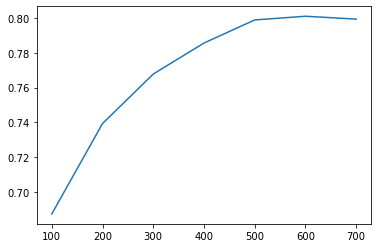

In [118]:
lse_only = res_df[~res_df.posmax & ~res_df.motifmax]
plt.plot(lse_only.seqlen, lse_only.val_auc)

In [119]:
sixh_only = res_df.groupby(["motifmax","posmax","motif_then_pos"]).agg({"val_auc" : "max"})
sixh_only

val_auc
motifmax posmax motif_then_pos          
False    False  True            0.800913
         True   False           0.752257
                True            0.712941
True     False  False           0.783872
                True            0.797998
         True   True            0.713973

Consistent with oRNAment results, although with slightly worse max performance. 

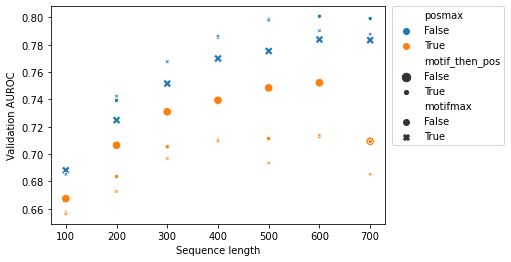

In [121]:
import seaborn as sns
res_df = pd.read_csv("results_mCross.tsv", sep="\t", index_col = False)
sns.scatterplot("seqlen", "val_auc", hue = "posmax", style="motifmax", size="motif_then_pos", data = res_df)
plt.xlabel("Sequence length")
plt.ylabel("Validation AUROC")
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)

'mCross_checkpoints/posmax0_motifmax0_len600.pt'

In [332]:
phys_net = biophysnn.PhysNet(HNRNPK_pwm, 
                            max_over_positions = False,
                             max_over_motifs = False, 
                             seq_len = 600)
check_point_filename = res_df.file.iloc[res_df.val_auc.argmax()]


Epoch 1 took 13.46s. Train loss: 1.2372 acc: 0.6200 auc 0.629. Val loss: 0.6539 acc: 0.6828 auc 0.745. Patience left: 10
Epoch 2 took 13.25s. Train loss: 0.6387 acc: 0.6693 auc 0.718. Val loss: 0.6305 acc: 0.6592 auc 0.723. Patience left: 10
Epoch 3 took 13.26s. Train loss: 0.6283 acc: 0.6623 auc 0.711. Val loss: 0.6315 acc: 0.6462 auc 0.721. Patience left: 9
Epoch 4 took 13.51s. Train loss: 0.6269 acc: 0.6610 auc 0.710. Val loss: 0.6429 acc: 0.6196 auc 0.724. Patience left: 8
Epoch 5 took 13.33s. Train loss: 0.6264 acc: 0.6618 auc 0.711. Val loss: 0.6454 acc: 0.6131 auc 0.729. Patience left: 7
Epoch 6 took 13.22s. Train loss: 0.6249 acc: 0.6655 auc 0.715. Val loss: 0.6304 acc: 0.6358 auc 0.747. Patience left: 10
Epoch 7 took 13.23s. Train loss: 0.6168 acc: 0.6742 auc 0.728. Val loss: 0.6349 acc: 0.6242 auc 0.745. Patience left: 9
Epoch 8 took 13.27s. Train loss: 0.6165 acc: 0.6722 auc 0.725. Val loss: 0.6308 acc: 0.6334 auc 0.748. Patience left: 8
Epoch 9 took 13.09s. Train loss: 0.61

## Fully de novo

In [39]:
val_auc_list = []
for i in range(10):
    de_novo_net = biophysnn.FinePhysNet(torch.randn_like(specific_pwms) * 0.3, 
                                     seq_len = 600)
    check_point_filename = "checkpoints/denovo_%i.pt" % i
    de_novo_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1) # val auc 0.763
    best_val_auc = np.max(val_aucs)
    print(i,best_val_auc)
    val_auc_list.append(best_val_auc)

0 0.8685930435377847
1 0.8665482581709729
2 0.8629281785120699
3 0.8675784534278486
4 0.8678971794891075
5 0.8699057263409823
6 0.8709894605114854
7 0.8698953447637634
8 0.8638996755098153
9 0.8662437269998693


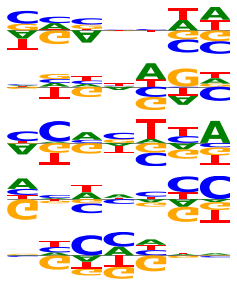

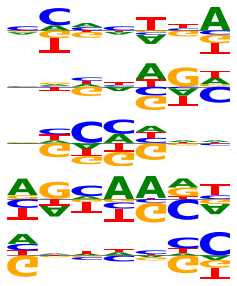

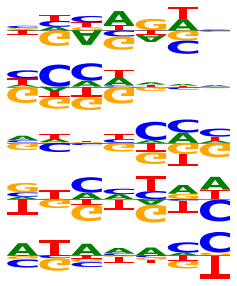

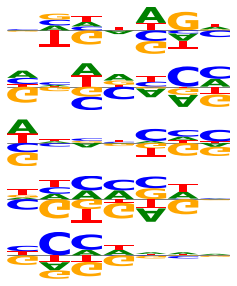

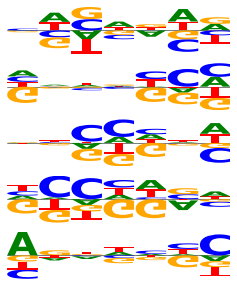

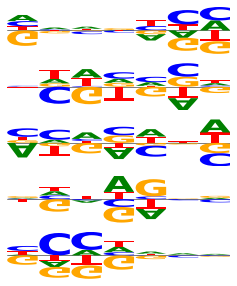

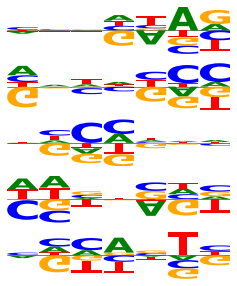

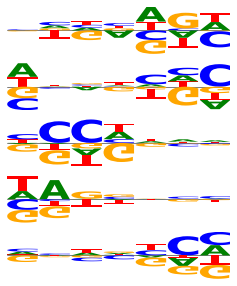

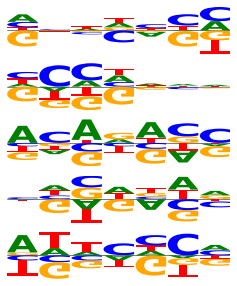

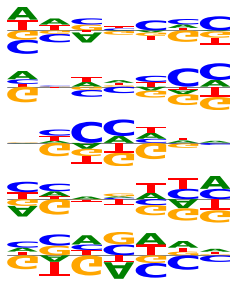

In [40]:
de_novo_net = biophysnn.FinePhysNet(torch.randn_like(specific_pwms),seq_len = 600)
for i in range(10):
    de_novo_net.load_state_dict(torch.load("checkpoints/denovo_%i.pt" % i))
    biophysnn.plot_motifs(de_novo_net.pwm.detach().cpu())

In [34]:
de_novo_net.pwm.mean(1)

tensor([[-1.6867, -1.6306, -1.7937, -1.8710, -1.6432, -1.5257, -1.6178],
        [-1.1227, -0.6703, -1.1111, -1.7953, -3.7895, -3.2095, -2.2036],
        [-1.9084, -2.2960, -1.7665, -2.2983, -1.8849, -2.1001, -1.6355],
        [-1.5222, -2.7695, -2.4268, -1.6714, -1.3523, -1.4006, -1.2399],
        [-2.6282, -1.7598, -1.2725, -0.7998, -2.4116, -1.7248, -1.3009]])

In [35]:
de_novo_net.pwm.std(1)

tensor([[0.7085, 0.4411, 0.3776, 0.5803, 0.5756, 0.3419, 0.5315],
        [0.2358, 0.3120, 0.8605, 1.2800, 3.1410, 2.8710, 2.1452],
        [2.1241, 2.5317, 1.6848, 1.9588, 1.6261, 1.9422, 0.8654],
        [2.7969, 3.3990, 3.2709, 0.7284, 0.4258, 0.3393, 0.1638],
        [3.2379, 1.6315, 0.4323, 0.3602, 2.7720, 1.8287, 0.7235]])

In [16]:
de_novo_net.motif_offset

Parameter containing:
tensor([-2.7468, -2.0183, -2.4517, -1.9290, -1.8008], requires_grad=True)

In [147]:
de_novo_net.offset

Parameter containing:
tensor(-2.6478, requires_grad=True)

In [17]:
de_novo_net.scale

tensor(6.3156)

(25, 3)

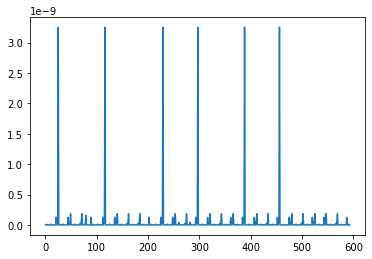

In [22]:
val_dataset = biophysnn.FastBedPeaksDataset(validation_data, genome, de_novo_net.seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=10000)
for x,y in validation_dataloader: 
    affin = de_novo_net(x)
    conv_lin = F.conv1d(x, de_novo_net.pwm) + de_novo_net.motif_offset[None,:,None]
    per_position = de_novo_net.scale * conv_lin.logsumexp(1) + de_novo_net.offset
    break

bound = y == 1.
idx = affin[bound].argmax().item()
plt.plot(per_position[bound][idx].detach().exp().numpy())

argmax_pos = per_position[bound][idx].argmax().item()
argmax_motif = conv_lin[bound][idx,:,argmax_pos].argmax().item()
argmax_pos, argmax_motif

In [23]:
conv_lin.logsumexp((0,2))

tensor([1.9340, 7.4762, 5.9430, 9.2793, 8.1886])

In [25]:
argmax_motif

3

## De novo one motif

In [43]:
val_auc_list = []
for i in range(10): 
    check_point_filename = "checkpoints/denovo_1motif_%i.pt" % i
    de_novo1_net = biophysnn.FinePhysNet(torch.randn((1,4,7)) * 0.1, 
                                     seq_len = 600)
    de_novo1_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1) # val auc 0.763
    best_val_auc = np.max(val_aucs)
    print(i,best_val_auc)
    val_auc_list.append(best_val_auc)

0 0.8505657551492903
1 0.8561197905830223
2 0.8552881016795677
3 0.8557662135175333
4 0.851083661918258
5 0.853555623966241
6 0.8545259622520553
7 0.8554834757643626
8 0.8557647055864178
9 0.8566482675878488


In [42]:
1

1

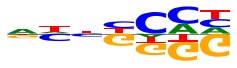

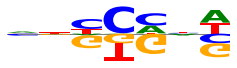

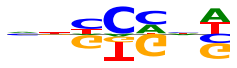

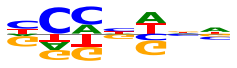

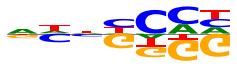

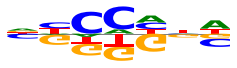

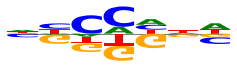

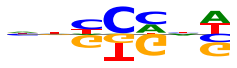

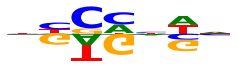

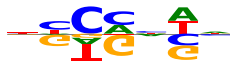

In [44]:
de_novo1_net = biophysnn.FinePhysNet(torch.randn((1,4,7)) * 0.1, 
                             seq_len = 600)
for i in range(10):
    check_point_filename = "checkpoints/denovo_1motif_%i.pt" % i
    de_novo1_net.load_state_dict(torch.load(check_point_filename))
    biophysnn.plot_motifs(de_novo1_net.pwm.detach().cpu())

In [ ]:
de_novo1_net = biophysnn.FinePhysNet(torch.randn((1,4,7)) * 0.1, 
                                 seq_len = 300)
de_novo1_net.load_state_dict(torch.load("checkpoints/denovo_1motif.pt"))
biophysnn.plot_motifs(de_novo1_net.pwm.detach().cpu())

In [29]:
de_novo1_net.motif_offset.data, de_novo1_net.scale.data, de_novo1_net.offset.data

(tensor([-1.0567]), tensor(5.5425), tensor(-2.8165))

<module 'biophysnn' from '/gpfs/commons/home/daknowles/pooledRBPs/biophysical_cnn/biophysnn.py'>

## With annealing

In [77]:
val_auc_list = []
for i in range(10): 
    check_point_filename = "checkpoints/anneal_1motif_%i.pt" % i
    de_novo1_net = biophysnn.FinePhysNet(torch.zeros((1,4,7)), 
                                     seq_len = 600, 
                                     annealing = True)
    de_novo1_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1) # val auc 0.763
    best_val_auc = np.max(val_aucs)
    print(i,best_val_auc)
    val_auc_list.append(best_val_auc)

1

0.7800840735435486 -8.622151374816895 0.1401272863149643 tensor([-6.5434])
0.8262924688996232
0.8216202259063721 -8.817441940307617 0.13645415008068085 tensor([-6.7903], device='cuda:0')
0.8261680037033825
0.7994122505187988 -8.671150207519531 0.13828051090240479 tensor([-6.6603], device='cuda:0')
0.825952844545468
0.7610723972320557 -8.663009643554688 0.14100995659828186 tensor([-6.4830], device='cuda:0')
0.8255625178473082
0.778719425201416 -8.672532081604004 0.13903144001960754 tensor([-6.5807], device='cuda:0')
0.8251086145254682
0.7452820539474487 -8.649787902832031 0.14181767404079437 tensor([-6.4204], device='cuda:0')
0.827463364699817
0.8254117965698242 -8.925460815429688 0.13528306782245636 tensor([-6.8676], device='cuda:0')
0.8246422998735239
0.7858014702796936 -8.672815322875977 0.139167919754982 tensor([-6.5998], device='cuda:0')
0.8266042841674377
0.7858378887176514 -8.692632675170898 0.13884317874908447 tensor([-6.5854], device='cuda:0')


KeyboardInterrupt: 

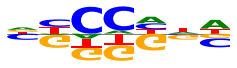

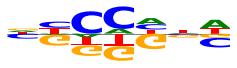

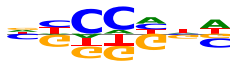

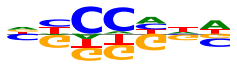

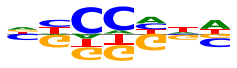

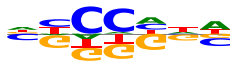

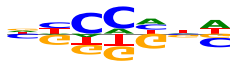

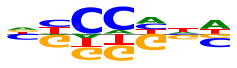

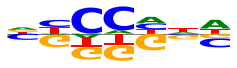

In [63]:
reload(biophysnn)
de_novo1_net = biophysnn.FinePhysNet(torch.randn((1,4,7)) * 0.1, 
                             seq_len = 600, annealing = True)
for i in range(10):
    check_point_filename = "checkpoints/anneal_1motif_%i.pt" % i
    de_novo1_net.load_state_dict(torch.load(check_point_filename))
    biophysnn.plot_motifs(de_novo1_net.pwm.detach().cpu())
    print(de_novo1_net.scale.item(), 
          de_novo1_net.offset.item(), 
          de_novo1_net.inverse_temp.item(), 
          de_novo1_net.motif_offset.data)
    de_novo1_net.inverse_temp_unc.data = torch.tensor(-3.)
    _, _, val_auc = biophysnn.eval_model(de_novo1_net, validation_data, genome)
    print(val_auc)

## Deflation

In [ ]:
val_auc_list = []

for i in range(10):
    de_novo1_net = biophysnn.FinePhysNet(torch.zeros((1,4,7)), 
                                 seq_len = 600, annealing = "fixed")
    check_point_filename = "checkpoints/anneal_1motif_%i.pt" % 0 # always initialize the same
    de_novo1_net.load_state_dict(torch.load(check_point_filename))

    de_novo1_net.inverse_temp_unc.data = torch.tensor(-3.)
    de_novo1_net.motif_offset.data = torch.cat( [ de_novo1_net.motif_offset.data, de_novo1_net.motif_offset.data ] )
    de_novo1_net.pwm.data = torch.cat( [ de_novo1_net.pwm.data, torch.zeros((1,4,7)) ], 0 )

    check_point_filename = "checkpoints/deflate_1_%i.pt" % i
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1)
    best_val_auc = np.max(val_aucs)
    print(i,best_val_auc)
    val_auc_list.append(best_val_auc)

0 0.8609639570745665


In [80]:
val_auc_list

[0.8609639570745665,
 0.8608881497513947,
 0.8622109438548944,
 0.8617966561714483,
 0.8562790492492978,
 0.8564250027984366,
 0.8610128009302664,
 0.8611504642032808,
 0.8565408044152865,
 0.8627855124400838]

tensor(0.1522)
tensor(0.1509)
tensor(0.1522)
tensor(0.1533)
tensor(0.1467)
tensor(0.1482)
tensor(0.1543)
tensor(0.1524)
tensor(0.1476)
tensor(0.1511)


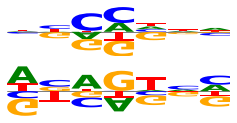

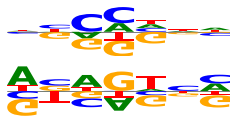

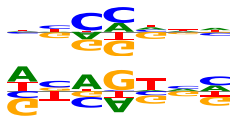

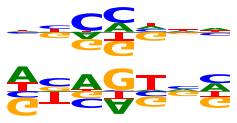

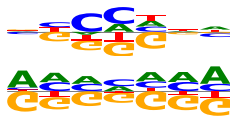

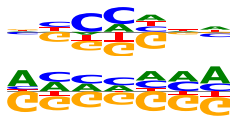

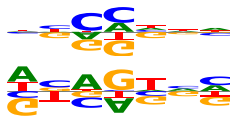

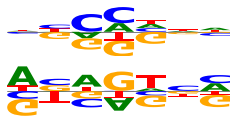

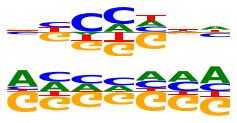

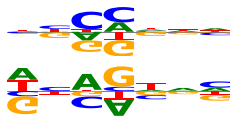

In [82]:
de_novo1_net = biophysnn.FinePhysNet(torch.zeros((2,4,7)), 
                             seq_len = 600, annealing = True)
for i in range(10):
    check_point_filename = "checkpoints/deflate_1_%i.pt" % i
    de_novo1_net.load_state_dict(torch.load(check_point_filename))
    biophysnn.plot_motifs(de_novo1_net.pwm.detach().cpu())
    print(de_novo1_net.inverse_temp.item())

The optimization falls into one of two distinct local optima, one with (A/T)NAGTN(A/C) which gives AUROC around 0.86 and another which rewards A/C runs and penalizes G. 

## Fixed then learned annealing

In [9]:
reload(biophysnn)
val_auc_list = []
annealing_schedule = 10**torch.arange(-3,-0.5,.5) # 0.001 to 0.1 in 4 steps
for i in range(10):
    de_novo1_net = biophysnn.FinePhysNet(torch.zeros((1,4,7)), 
                                 seq_len = 600, annealing = True)
    check_point_filename = "checkpoints/anneal_1motif_%i.pt" % 0 # always initialize the same
    de_novo1_net.load_state_dict(torch.load(check_point_filename))

    de_novo1_net.motif_offset.data = torch.cat( [ de_novo1_net.motif_offset.data, de_novo1_net.motif_offset.data ] )
    de_novo1_net.pwm.data = torch.cat( [ de_novo1_net.pwm.data, torch.zeros((1,4,7)) ], 0 )

    check_point_filename = "checkpoints/deflate_1_%i_fixedanneal.pt" % i
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                                       annealing_schedule = annealing_schedule,
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1)
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1)
    best_val_auc = np.max(val_aucs)
    print(i,best_val_auc)
    val_auc_list.append(best_val_auc)

1

This does give basically the same secondary motif each time, but it looks pretty weird! Does give better AUC though! 

0.1748240739107132
0.17474083602428436
0.17494630813598633
0.17493586242198944
0.17482402920722961
0.17478249967098236
0.1749017834663391
0.17491328716278076
0.17476391792297363
0.1748443841934204


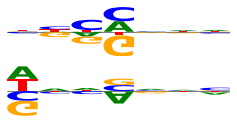

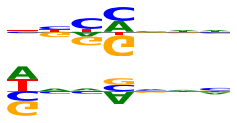

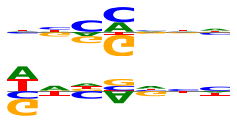

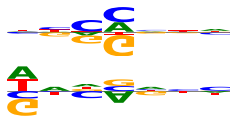

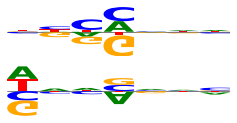

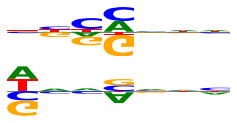

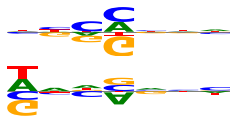

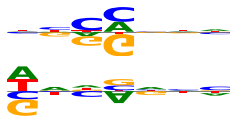

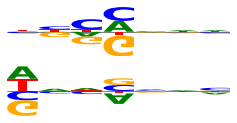

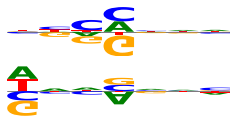

In [11]:
de_novo1_net = biophysnn.FinePhysNet(torch.zeros((2,4,7)), 
                             seq_len = 600, annealing = True)
val_auc_list = []
for i in range(10):
    check_point_filename = "checkpoints/deflate_1_%i_fixedanneal.pt" % i
    de_novo1_net.load_state_dict(torch.load(check_point_filename))
    _,_,val_auc = biophysnn.eval_model(de_novo1_net, 
                validation_data, 
                genome)
    val_auc_list.append(val_auc)
    biophysnn.plot_motifs(de_novo1_net.pwm.detach().cpu())
    print(de_novo1_net.inverse_temp.item())

In [12]:
val_auc_list

[0.865779199921989,
 0.8661822216072159,
 0.865211936841583,
 0.8646190630162941,
 0.8653282000699991,
 0.8666005781624655,
 0.8640742275679726,
 0.8658437532889822,
 0.8660585632277122,
 0.8663116253782104]

1

## Deflation continued

In [ ]:
reload(biophysnn)
val_auc_list = []
annealing_schedule = 10**torch.arange(-3,-0.5,.5) # 0.001 to 0.1 in 4 steps
de_novo1_net = biophysnn.FinePhysNet(torch.zeros((1,4,7)), 
                                 seq_len = 600, annealing = True)
check_point_filename = "checkpoints/anneal_1motif_%i.pt" % 0 # always initialize the same
de_novo1_net.load_state_dict(torch.load(check_point_filename))

prev_checkpoint = "checkpoints/deflation_0.pt"
torch.save(de_novo1_net.state_dict(), prev_checkpoint)

for i in range(1,6):
    
    next_checkpoint = "checkpoints/deflation_%i.pt" % i
    if os.path.isfile(next_checkpoint): 
        prev_checkpoint = next_checkpoint
        continue
    de_novo1_net = biophysnn.FinePhysNet(torch.zeros((i,4,7)), 
                                 seq_len = 600, annealing = True)
    de_novo1_net.load_state_dict(torch.load(prev_checkpoint))
    
    de_novo1_net.motif_offset.data = torch.cat( [ de_novo1_net.motif_offset.data,
                                                 de_novo1_net.motif_offset.data.mean(0,keepdim=True) ] )
    de_novo1_net.pwm.data = torch.cat( [ de_novo1_net.pwm.data, 
                                        torch.zeros((1,4,7)) ], 0 )
    _ = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           annealing_schedule = annealing_schedule,
                                                           verbose = False, 
                                                           check_point_filename = next_checkpoint,
                                                           lr = 0.1)
    _, _, _, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           verbose = False, 
                                                           check_point_filename = next_checkpoint,
                                                           lr = 0.1)
    best_val_auc = np.max(val_aucs)
    print(i,best_val_auc)
    val_auc_list.append(best_val_auc)
    prev_checkpoint = next_checkpoint

1 0.8681216190465051
2 0.8691135714576443
3 0.8701008007127604
4 0.8717535494116111


In [31]:
    check_point_filename = "checkpoints/deflate_%i.pt" % i
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           annealing_schedule = annealing_schedule,
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1)

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

In [22]:

for i in range(1,6):
    if i>1: 
        de_novo1_net.motif_offset.data = torch.cat( [ de_novo1_net.motif_offset.data,
                                                     de_novo1_net.motif_offset.data.mean(0,keepdim=True) ] )
    de_novo1_net.pwm.data = torch.cat( [ de_novo1_net.pwm.data, 
                                        torch.zeros((1,4,7), 
                                                    device = de_novo1_net.pwm.data.device) ], 0 )

    check_point_filename = "checkpoints/deflate_%i.pt" % i
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           annealing_schedule = annealing_schedule,
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1)
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                           train_data, 
                                                           validation_data, 
                                                           genome, 
                                                           verbose = False, 
                                                           check_point_filename = check_point_filename,
                                                           lr = 0.1)
    best_val_auc = np.max(val_aucs)
    print(i,best_val_auc)
    val_auc_list.append(best_val_auc)

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

In [26]:
{ k:v.shape for k,v in de_novo1_net.named_parameters() }

{'pwm': torch.Size([3, 4, 7]),
 'motif_offset': torch.Size([3]),
 'scale_unc': torch.Size([]),
 'offset': torch.Size([]),
 'inverse_temp_unc': torch.Size([])}

In [23]:
de_novo1_net.motif_offset.data.shape

torch.Size([3])

In [25]:
de_novo1_net.pwm.data.shape

torch.Size([3, 4, 7])

In [18]:
de_novo1_net.motif_offset.data.mean(0,keepdim=True).shape

torch.Size([1])

In [ ]:
de_novo1_net = biophysnn.FinePhysNet(torch.zeros((2,4,7)), 
                             seq_len = 600, annealing = True)
val_auc_list = []
for i in range(10):
    check_point_filename = "checkpoints/deflate_%i.pt" % i
    de_novo1_net.load_state_dict(torch.load(check_point_filename))
    _,_,val_auc = biophysnn.eval_model(de_novo1_net, 
                validation_data, 
                genome)
    val_auc_list.append(val_auc)
    biophysnn.plot_motifs(de_novo1_net.pwm.detach().cpu())
    print(de_novo1_net.inverse_temp.item())

## Test flipped CNN

In [ ]:
test_acc_flipped = {}
seq_lens = {}
test_acc_regular = {}
for num_filters in range(1,17): 
    print(num_filters, end = " ")
    flipped_cnn = CNN_1d(use_flipping=True, nchannels = [4, num_filters], n_hidden = 16, filter_widths = [10])
    seq_lens[num_filters] = flipped_cnn.seq_len
    flipped_cnn, train_accs, val_accs = train_model(flipped_cnn, train_data, validation_data, verbose = False)
    test_dataset = BedPeaksDataset(test_data, genome, flipped_cnn.seq_len)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
    test_loss, test_acc_flipped[num_filters] = run_one_epoch(test_dataloader, flipped_cnn, None)
    #test_acc_flipped # .662, .666 for FlippedConv, .66 without flipping, .665 with NewFlipping

    regular_cnn = CNN_1d(use_flipping=False,  nchannels = [4, num_filters], n_hidden = 16, filter_widths = [11])
    regular_cnn, train_accs, val_accs = train_model(regular_cnn, train_data, validation_data, verbose = False)
    test_dataset = BedPeaksDataset(test_data, genome, regular_cnn.seq_len)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
    test_loss, test_acc_regular[num_filters] = run_one_epoch(test_dataloader, regular_cnn, None)

plt.plot(list(seq_lens.values()))

In [ ]:
test_acc_flipped_values = np.array(list(test_acc_flipped.values()))
print("%.3f +/- %.3f" % (test_acc_flipped_values.mean(), test_acc_flipped_values.std()))

In [ ]:
for i in range(10): 
    print(i, end = " ")

test_acc_regular_values = np.array(list(test_acc_regular.values()))
print("%.3f +/- %.3f" % (test_acc_regular_values.mean(), test_acc_regular_values.std()))

In [ ]:
test_acc_regular_values

Across 10 replicates: biophysical 0.668 +/- 0.003, regular 0.665 +/- 0.007 (so probably not statistically signicant?) 